# Investigating Failure Modes and Enhancements of Physics-Informed Neural Networks for Power System Dynamics

## Vanilla NNs Numerical Experiments

#### Karan Kataria
#### Supervisor: Dr. Subhash Lakshminarayana

In [2]:
%%capture

import sys
import os

# Add ODE_numerical_solver module to PATH variable
sys.path.insert(
    1,
    "/Users/karankataria/Desktop/PINNs_PSs/src/numerical_experiments"
)

sys.path.insert(
    2,
    "/Users/karankataria/Desktop/PINNs_PSs/src/numerical_solutions"
)

import matplotlib.pyplot as plt
import numpy as np
import torch
import scienceplots
from torchinfo import summary
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from pyhessian import hessian

from utils import set_global_seed
from pinn_architecture import PINN
from global_constants import *
from loss_functions import l2_error
from ODE_numerical_solver import swing_ODEs_solver

## 1.0) Set up script

In [3]:
# Config matplotlib and define plot constants
plt.style.use("science")
plt.rcParams["text.usetex"] = True

# Color map for the visualisations
CMAP: str = "seismic" 

# Device to perform tensor operations on (GPU to CPU)

# NB: GPUs were not needed; MPS was avaliable on my Mac but did not showcase significant
# computational benefits
DEVICE: str = "cpu"

In [4]:
# Define and fix seed
SEED: int = 20
set_global_seed(SEED)

assert type(SEED) is int

print(f"Seed set: {SEED}")

Seed set: 20


In [5]:
# Specify the parameter to be varied and its symbol
VARYING_PARAM: str = "mechanical_power"
VARYING_PARAM_NOTATION: str = "$P^m$"
print(f"Parameter: {VARYING_PARAM}")

Parameter: mechanical_power


In [6]:
# Path to save images and flag
PATH_TO_IM_DIR: str = f"/Users/karankataria/Desktop/PINNs_PSs/data/visualisations/loss_landscapes/{VARYING_PARAM}/"

print(f"Absolute Export Path: {PATH_TO_IM_DIR}")

Absolute Export Path: /Users/karankataria/Desktop/PINNs_PSs/data/visualisations/loss_landscapes/mechanical_power/


### 1.1) Set flags

In [7]:
# Boolean constant only adds title on subplots on the top most row (first random seed 0)
TOP_PLOT: bool = True

# Toggle flag on whether or not to export data and images
SAVE: bool = False

SEMI_SUPERVISED: bool = False

print(f"Plots and files are exported from this file?\t{SAVE}")
print(f"Semi-supervised learning enabled?\t{SEMI_SUPERVISED}")

Plots and files are exported from this file?	False
Semi-supervised learning enabled?	False


### 1.2) Initialise SMIB swing equation parameters and loss term weights, including variable parameter and its values

In [8]:
# Param dictionary
PARAM_DICT: dict[list[float]] = {
    "DAMPING": [0.00015, 0.0015, 0.015, 0.15, 1.5],
    "INERTIA": [0.01, 0.1325, 0.250, 0.3775, 0.5],
    "MECHANICAL_POWER": [0.0, 0.0475, 0.095 , 0.1425, 0.19]
}

# Specify the range of parameter values
PARAM_LIST: list[float] = PARAM_DICT[VARYING_PARAM.upper()]

DAMPING: torch.Tensor = torch.tensor(data=[[0.15]])
INERTIA: torch.Tensor = torch.tensor(data=[[0.25]])
# MECHANICAL_POWER: torch.Tensor = torch.tensor(data=[[0.13]])

### 1.3) Create subdirectories required for data export (continue if already created)

In [9]:
# Ensure desired folder has all intended subdirectories to store the results in
parent_dir = f"{PATH_TO_IM_DIR}/vanilla_nn/"

# Define all subdirectories to be created
required_subdirs = [
    "l2_errors",
    "nn_pred_vs_rk45",
    "rel_error_per_epoch",
    "training_loss",
    "gradient_norms",
    "l2_errors/semi_supervised"
]

# Create subdirectories if not existent, else continue
for subdir in required_subdirs:
    full_path = os.path.join(parent_dir, subdir)
    if not os.path.exists(full_path):
        os.makedirs(full_path, exist_ok=True)
        print(f"Created: {full_path}")
    else:
        print(f"Already exists: {full_path}")

Already exists: /Users/karankataria/Desktop/PINNs_PSs/data/visualisations/loss_landscapes/mechanical_power//vanilla_nn/l2_errors
Already exists: /Users/karankataria/Desktop/PINNs_PSs/data/visualisations/loss_landscapes/mechanical_power//vanilla_nn/nn_pred_vs_rk45
Already exists: /Users/karankataria/Desktop/PINNs_PSs/data/visualisations/loss_landscapes/mechanical_power//vanilla_nn/rel_error_per_epoch
Already exists: /Users/karankataria/Desktop/PINNs_PSs/data/visualisations/loss_landscapes/mechanical_power//vanilla_nn/training_loss
Already exists: /Users/karankataria/Desktop/PINNs_PSs/data/visualisations/loss_landscapes/mechanical_power//vanilla_nn/gradient_norms
Already exists: /Users/karankataria/Desktop/PINNs_PSs/data/visualisations/loss_landscapes/mechanical_power//vanilla_nn/l2_errors/semi_supervised


### 1.4) Set up vanilla NN global variables and training configurations

In [10]:
# Print the training loss every specified number of epochs
PRINT_TRAINING_LOSS_EVERY_EPOCH: int = 1_000

# Adam and L-BFGS learning rates
LEARNING_RATE: float = 0.01
LEARNING_RATE_LBFGS: float = 1.0

# Adam Learning Rate (LR) scheduler
PATIENCE: int = 10
SCHEDULER_FACTOR: float = 0.9

# L-BFGS number of preceeding vectors to retain to compute Hessian approximation
HISTORY: int = 100

# Define the parameters for the ODE numerical solution
INITIAL_STATE: torch.tensor = torch.tensor(
    data=np.array([0.1, 0.1]), dtype=torch.float64
).to(device=DEVICE)

# Define Epochs (Adam and total)
EPOCHS: int = 15_000
EPOCHS_ADAM: int = 10_000
print(f"Number of total epochs: {EPOCHS}")
print(f"Number of Adam epochs: {EPOCHS_ADAM}")

# Specify activation function
ACTIVATION: str = "tanh"
print(f"Activation function: {ACTIVATION}")

# Specify the number of hidden units per layer
HIDDEN_UNITS: int = 10
print(f"Number of hidden units per layer: {HIDDEN_UNITS}")

Number of total epochs: 15000
Number of Adam epochs: 10000
Activation function: tanh
Number of hidden units per layer: 10


### 1.5) Obtain and collect all numerical solutions for each parameter value using Runge-Kutta 4,5 (RK45)

#### NB: The number of total solution points from RK45:

$$
N = \frac{(T - t_0)}{\Delta t} + 1
$$

In [11]:
# Define lists to collect numerical solutions (time, exact points, noisy points)
numerical_solutions_exact = []
numerical_solutions_noisy = []
numerical_domain = None

# Use TIMESTEP_FLOAT instead of TIMESTEP tensor due to floating-point errors
TIMESTEP_FLOAT = 0.1

# Define number of total data points from numerical solution, N
N: int = int((FINALTIME - T0)/(TIMESTEP_FLOAT) + 1)
print(f"Total number of data points from RK45, N = {N}")

# Define percentage of total dataset N to select for training
TRAIN_TEST_SPLIT: float = 0.2
print(f"Percentage of data to be used for training: {TRAIN_TEST_SPLIT * 100}%")

# Obtain numerical solution for each corresponding parameter value
for param in PARAM_LIST:

    MECHANICAL_POWER: torch.Tensor = torch.tensor(data=[[param]])

    # Obtain RK45 solution of the SMIB swing equation for the choosen parameter value
    solution, noisy_solution, numerical_times = swing_ODEs_solver(
    initial_time=T0,
    initial_state=INITIAL_STATE.detach().numpy(),
    final_time=FINALTIME,
    timestep=TIMESTEP_FLOAT,
    inertia=INERTIA.item(),
    damping=DAMPING.item(),
    mechanical_power=MECHANICAL_POWER.item(),
    voltage_magnitude=VOLTAGE.item(),
    include_controllers=False,
    voltages=np.array([VOLTAGES.item()]),
    phase_angles=np.array([PHASE_ANGLES.item()]),
    susceptances=np.array([SUSCEPTANCES.item()]),
    file_name="test_run",
    save_output_to_file=False,
    controller_proportional=0.05,
    controller_integral=0.1
    )

    # NB: Numerical domain remains constant for all parameter values
    if numerical_domain is None:
        numerical_domain = numerical_times

    # Collect numerical solutions (excat and noisy)
    numerical_solutions_exact.append(solution)
    numerical_solutions_noisy.append(noisy_solution)

# Reshape numerical solutions into a rank-2 tensor of shape (No. of params values, 2, N)
numerical_solutions_exact = np.array(numerical_solutions_exact)
numerical_solutions_noisy = np.array(numerical_solutions_noisy)

# Also create PyTorch tensors
numerical_solutions_exact_tensor = torch.tensor(numerical_solutions_exact).to(device=DEVICE)
numerical_solutions_noisy_tensor = torch.tensor(numerical_solutions_noisy).to(device=DEVICE)
times_tensor = torch.tensor(numerical_domain[:, None].astype(np.float32), requires_grad=True).to(device=DEVICE)

# Obtain a RANDOM array of indices to index the numerical solution to subsample training data
# for vanilla NN
rand_index = np.random.choice(np.arange(1, N, 1), replace=False, size=int(np.floor(N*TRAIN_TEST_SPLIT)))
rand_index = np.append(rand_index, 0)

print(f"Number of training points: {rand_index.shape[0]}")

Total number of data points from RK45, N = 201
Percentage of data to be used for training: 20.0%
Number of training points: 41


In [12]:
# Obtain test indices to obain a test data
test_indices = np.setdiff1d(np.arange(0, N, 1), rand_index)
assert int(test_indices.shape[0] + rand_index.shape[0]) == N

print(f"Training data: {rand_index.shape[0]}\nTest data: {N - rand_index.shape[0]}")

Training data: 41
Test data: 160


### 1.6) Define mesh for two-dimensional loss landscape projections and sample Gaussian random orthonormal directions

$$
(\alpha_1, \alpha_2) \in [-2, 2]^2
$$

$$
\mathcal{F}(\alpha_1, \alpha_2) := \mathcal{L}(\hat{\boldsymbol{\theta}} + \alpha_1 \mathbf{v}_1 + \alpha_2 \mathbf{v}_2)
$$

$$
\hat{\boldsymbol{\theta}} := \underset{\boldsymbol{\theta}\in \Theta}{\arg \min} \hspace{1mm} \mathcal{L}(\boldsymbol{\theta})
$$

In [13]:
# Define mesh
LB: int = -2
NUM_VERTICES: int = 40  # (40 x 40) structured grid
INCREMENT: float = -2*LB / NUM_VERTICES

alpha_1: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
alpha_2: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
ALPHA_1, ALPHA_2 = np.meshgrid(alpha_1.numpy(), alpha_2.numpy())

In [14]:
# Obtain the dimensionality of the parameter space
TOTAL_NUM_PARAMS: int = summary(model=PINN(activation=ACTIVATION).to(device=DEVICE)).total_params

print(f"Total number of learnable parameters: {TOTAL_NUM_PARAMS}\n")

# Sample Gaussian random direction vectors as in Li et al. (2018)
direction_vec_1: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)
direction_vec_2: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Make into a unit vector (normalisation)
direction_vec_1 = direction_vec_1 / torch.norm(input=direction_vec_1)

# Use the Gram-Schmidt process to convert linearly independent vectors
# into orthonormal vectors
direction_vec_2 = (
    direction_vec_2 - torch.dot(direction_vec_2, direction_vec_1) * direction_vec_1
)

# Make into a unit vector (normalisation)
direction_vec_2 = direction_vec_2 / torch.norm(input=direction_vec_2)

# Test orthogonality and normality
assert torch.dot(direction_vec_1, direction_vec_2) < 1e-6
assert torch.norm(input=direction_vec_1) - 1 < 1e-8
assert torch.norm(input=direction_vec_2) - 1 < 1e-8

# Obtain sum of elements for both direction vectors to ensure seed consistency
print("v_1^{T} {1}: " + f"{torch.sum(direction_vec_1)}")
print("v_2^{T} {1}: " + f"{torch.sum(direction_vec_2)}")

Total number of learnable parameters: 800

v_1^{T} {1}: 1.0519237518310547
v_2^{T} {1}: -1.4218571186065674


## 2.0) Initialise training loop across the five parameter values

$$
\mathcal{L}_{\mathrm{NN}}(\boldsymbol{\theta}) := \frac{1}{N_{\mathcal{D}}} \sum_{i=1}^{N_{\mathcal{D}}} \Big( \hat{\delta}(t_i^{\mathcal{D}}) - \delta_i^{\mathcal{D}} \Big)^2
$$

for NOISY training data $\{t_i^{\mathcal{D}}, \delta_i^{\mathcal{D}}\}_{i=1}^{N_\mathcal{D}}$.

### 2.1) Define lists to accumulate data collected throughout training (e.g. gradient norms of each loss term) for each parameter value

In [15]:
# Collect all trained PINN models for each parameter
nn_models: list[callable] = []

# Collect training losses across each parameter value
training_losses_per_param: list[float] = []

# Collect test losses per epoch across each parameter
test_losses_per_param_per_epoch: list[float] = []

# Collect 2-norm of gradients of loss wrt weights/biases for each parameter per epoch
gradient_norm_per_param: list[float] = []

### 2.2) Begin training loop across each of the five parameter values

In [16]:
# Instantiate standard training-data based MSE loss function
loss_MSE = torch.nn.MSELoss()

# Iterate over all parameter values
for index, param in enumerate(PARAM_LIST):

    # Ensure each network is initialised at the same point in parameter space
    set_global_seed(SEED)

    print(f"Param value {index+1}")
    print("----------------------\n")

    # Obtain NOISY training data
    # NB: Training data is only the phase angle
    training_times = torch.tensor(
        data=np.array([numerical_domain[id] for id in rand_index])[:, None],
        requires_grad=True,
        dtype=torch.float32
    ).to(device=DEVICE)

    training_data = torch.tensor(
        data=np.array([numerical_solutions_noisy[index, 0, id] for id in rand_index])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)

    # Obtain EXACT test data
    # NB: Test data includes BOTH phase angle and angular frequency data points
    test_times = torch.tensor(
        data=np.array([numerical_domain[id] for id in test_indices])[:, None],
        requires_grad=True,
        dtype=torch.float32
    ).to(device=DEVICE)

    ground_truth_phase_angle = torch.tensor(
        data=np.array([numerical_solutions_exact[index, 0, id] for id in test_indices])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)

    ground_truth_angular_frequency = torch.tensor(
        data=np.array([numerical_solutions_exact[index, 1, id] for id in test_indices])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)

    label_vector = torch.stack(tensors=(ground_truth_phase_angle, ground_truth_angular_frequency), dim=0)

    # Instantiate vanilla NN, optimisers and learning rate scheduler
    nn = PINN(activation=ACTIVATION).to(device=DEVICE)

    # Compute total sum of weightd and biases for seed consistency check
    total_sum = sum(p.sum().item() for p in nn.parameters())
    print(f"Sum of all weights: {total_sum:.6f}")

    # Instantiate the Adam optimiser and learning rate scheduler
    optimiser_adam = torch.optim.Adam(params=nn.parameters(), lr=LEARNING_RATE)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimiser_adam, patience=PATIENCE, factor=SCHEDULER_FACTOR
    )

    # Instantiate the L-BFGS optimiser
    optimiser_lbfgs = torch.optim.LBFGS(
        params=nn.parameters(),
        lr=LEARNING_RATE_LBFGS,
        history_size=HISTORY,
        line_search_fn="strong_wolfe",
        max_iter=100_000,
        max_eval=100_000,
        tolerance_change= np.finfo(float).eps
    )

    # Define closure to re-compute loss in a single epoch, which is required for L-BFGS
    def closure():
        optimiser_lbfgs.zero_grad()
        
        phase_angle_pred = nn.forward(
            data=training_times, initial_state=INITIAL_STATE
        )

        loss = loss_MSE(phase_angle_pred, training_data)      
        loss.backward()
        return loss

    # Define array to collect training loss every epoch
    training_loss: list[float] = []

    # Define list to collect test losses every epoch (L2 relative error)
    test_loss: list[float] = []

    # Define list to collect 2-norm of the gradient of the loss wrt the params every epoch
    # ADAM only
    gradient_norm: list[float] = []

    # Perform the training loop using full-batch training
    for epoch in (range(1, EPOCHS+1)):

        # Evaluate vanilla NN performance on test data by computing L2 relative error
        nn.eval()
        phase_angle_pred_test = nn.forward(data=test_times, initial_state=INITIAL_STATE)
        nn.train()

        angular_frequency_pred_test = torch.autograd.grad(
            outputs=phase_angle_pred_test,
            inputs=test_times,
            grad_outputs=torch.ones_like(phase_angle_pred_test),
            create_graph=False,
            retain_graph=False
        )[0]

        pred_vector: torch.Tensor = torch.stack(
            tensors=(phase_angle_pred_test, angular_frequency_pred_test),
            dim=0
        )

        _, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)
        test_loss.append(l2_rel.item())

        # Obtain losses
        phase_angle_pred = nn.forward(
            data=training_times, initial_state=INITIAL_STATE
        )

        # Evaluate training performance via the MSE loss function and backpropagate
        tot_loss = loss_MSE(phase_angle_pred, training_data)      
        training_loss.append(tot_loss.item())

        if epoch == 1:
            print(f"Initial training loss: {tot_loss.item()}")

        # Backpropogate using reverse/backward-mode AD using Adam or L-BFGS
        if epoch <= EPOCHS_ADAM:
            optimiser_adam.zero_grad()
            tot_loss.backward()

            # Obtain gradient norm of TOTAL loss with respect to network parameters
            total_norm = 0
            total_num_params = 0
            for w_n_b in nn.parameters():
                if w_n_b.grad is not None:
                    total_num_params += w_n_b.flatten().shape[0]
                    param_norm = w_n_b.grad.detach().norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            gradient_norm.append(total_norm)

            assert total_num_params == TOTAL_NUM_PARAMS

            # Backpropagate
            optimiser_adam.step()
            lr_scheduler.step(metrics=tot_loss)

            if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
                print(f"{VARYING_PARAM_NOTATION}={param:.2e}\t\tEpoch: {epoch}\t\tTraining loss: {tot_loss.item()}")
        else:
            optimiser_lbfgs.step(closure=closure)
            if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
                print(f"{VARYING_PARAM_NOTATION}={param:.2e}\t\tEpoch: {epoch}\t\tRunning L-BFGS")

    # Append the trained model and the per epoch statistics to the corresponding lists
    nn_models.append(nn)
    training_losses_per_param.append(training_loss)
    test_losses_per_param_per_epoch.append(test_loss)
    gradient_norm_per_param.append(gradient_norm)

Param value 1
----------------------

Sum of all weights: 8.198508
Initial training loss: 0.015393099747598171
$P^m$=0.00e+00		Epoch: 1000		Training loss: 2.9336088118725456e-05
$P^m$=0.00e+00		Epoch: 2000		Training loss: 1.4304072465165518e-05
$P^m$=0.00e+00		Epoch: 3000		Training loss: 3.2754983294580597e-06
$P^m$=0.00e+00		Epoch: 4000		Training loss: 2.9011939659540076e-06
$P^m$=0.00e+00		Epoch: 5000		Training loss: 2.7088256047136383e-06
$P^m$=0.00e+00		Epoch: 6000		Training loss: 2.545811639720341e-06
$P^m$=0.00e+00		Epoch: 7000		Training loss: 2.419935526631889e-06
$P^m$=0.00e+00		Epoch: 8000		Training loss: 2.3231716568261618e-06
$P^m$=0.00e+00		Epoch: 9000		Training loss: 2.233416353192297e-06
$P^m$=0.00e+00		Epoch: 10000		Training loss: 2.1421828932943754e-06
$P^m$=0.00e+00		Epoch: 11000		Running L-BFGS
$P^m$=0.00e+00		Epoch: 12000		Running L-BFGS
$P^m$=0.00e+00		Epoch: 13000		Running L-BFGS
$P^m$=0.00e+00		Epoch: 14000		Running L-BFGS
$P^m$=0.00e+00		Epoch: 15000		Running L-B

## 3.0) Obtain loss landscape projections onto two-dimensional subspaces by evaluating final loss for each network on a 40x40 structured grid

### 3.1) Random direction subspace

In [17]:
# Collect the loss landscapes for random directions for each parameter value
loss_landscapes_random: list[float] = []

# Iterate over all parameter values
for index, (nn, param) in enumerate(zip(nn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    # Varying parameter
    MECHANICAL_POWER: torch.Tensor = torch.tensor(data=[[param]])

    # Place nn in evaluation mode
    nn.eval()
    
    # Extract the post-training parameters (theta hat)
    MINIMISER = parameters_to_vector(nn.parameters()).detach()

    # Get NOISY training data
    training_data = torch.tensor(
        data=np.array([numerical_solutions_noisy[index, 0, id] for id in rand_index])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)

    training_times = torch.tensor(
        data=np.array([numerical_domain[id] for id in rand_index])[:, None],
        requires_grad=True,
        dtype=torch.float32
    ).to(device=DEVICE)

    # Define list to collect the loss landscape across the mesh for a single value
    loss_landscape_random: list[float] = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            # Perturb minimiser in the random direction subspace
            perturbation = MINIMISER + (i * direction_vec_1) + (j * direction_vec_2)

            # Update network parameters
            vector_to_parameters(vec=perturbation, parameters=nn.parameters())

            # Forward propagate with updated parameters and obtain losses
            phase_angle_pred = nn.forward(
                data=training_times, initial_state=INITIAL_STATE
            )

            loss_perturb_random = loss_MSE(phase_angle_pred, training_data)
            loss_landscape_random.append(loss_perturb_random.detach().numpy())

            # Reset network parameters back to the original post-training minimiser
            vector_to_parameters(vec=MINIMISER, parameters=nn.parameters())

    # Reshape and append loss grid to the corresponding list
    loss_landscape_random = np.array(loss_landscape_random).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_random.append(loss_landscape_random)

Param value 1
----------------------

Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



### 3.2) Hessian-based direction subspace

In [21]:
# Collect the loss landscapes for Hessian-based directions for each parameter value
loss_landscapes_hessian = []

# Iterate over all parameter values
for index, (nn, param) in enumerate(zip(nn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    # Varying parameter
    MECHANICAL_POWER: torch.Tensor = torch.tensor(data=[[param]])

    # Place PINN in evaluation mode
    nn.eval()
    
    # Extract the post-training parameters (theta hat)
    MINIMISER = parameters_to_vector(nn.parameters()).detach()

    # Get NOISY training data
    training_data = torch.tensor(
        data=np.array([numerical_solutions_noisy[index, 0, id] for id in rand_index])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)

    training_times = torch.tensor(
        data=np.array([numerical_domain[id] for id in rand_index])[:, None],
        requires_grad=True,
        dtype=torch.float32
    ).to(device=DEVICE)

    # Obtain the top-2 eigenvectors of the loss Hessian   
    hessian_comp = hessian(nn, loss_MSE, data=(training_times, training_data), cuda=False)
    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
    
    first_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[0]]
    first_eigenvector = torch.cat(first_eigenvector, dim=0)

    second_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[1]]
    second_eigenvector = torch.cat(second_eigenvector, dim=0)

    # Define list to collect the loss landscape across the mesh for a single value
    loss_landscape_hessian: list[float] = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            # Perturb minimiser in the Hessian-based direction subspace
            perturbation_hessian = MINIMISER + (i * first_eigenvector) + (j * second_eigenvector)
            
            # Update network parameters
            vector_to_parameters(vec=perturbation_hessian, parameters=nn.parameters())

            # Forward propagate with updated parameters and obtain losses
            phase_angle_pred = nn.forward(
                data=training_times, initial_state=INITIAL_STATE
            )

            loss_perturb_hessian = loss_MSE(phase_angle_pred, training_data)
            loss_landscape_hessian.append(loss_perturb_hessian.detach().numpy())

            # Reset network parameters back to the original post-training minimiser
            vector_to_parameters(vec=MINIMISER, parameters=nn.parameters())
            
    # Reshape and append loss grid to the corresponding list
    loss_landscape_hessian = np.array(loss_landscape_hessian).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_hessian.append(loss_landscape_hessian)

Param value 1
----------------------

Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



Letting $\mathcal{F}_{\mathrm{rand}}$ and $\mathcal{F}_{{H}}$ be the random and Hessian-based loss landscape projections, respectively, 

$$
\mathcal{F}_{\mathrm{rand}}(0,0) = \mathcal{F}_{{H}}(0,0) = \mathcal{L}(\hat{\boldsymbol{\theta}})
$$

In [28]:
ORIG_LOSS_INDEX: int = NUM_VERTICES//2

# First check if the values of the loss in both loss landscapes at alpha_1 = alpha_2 = 0 are equal
for idx, (loss, random, hessian_) in enumerate(zip(training_losses_per_param, loss_landscapes_random, loss_landscapes_hessian)):
    
    print(f"Parameter {idx+1}")
    print(r"L(\theta)="+f"{loss[-1]}")
    print(f"F_rand(0,0) = {random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX]}")
    print(f"F_H(0,0) = {hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX]}\n")

    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], atol=1e-8, rtol=1e-8)
    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)
    assert np.isclose(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)

Parameter 1
L(\theta)=2.141946197298239e-06
F_rand(0,0) = 2.141946197298239e-06
F_H(0,0) = 2.141946197298239e-06

Parameter 2
L(\theta)=2.6847587832889985e-06
F_rand(0,0) = 2.6847587832889985e-06
F_H(0,0) = 2.6847587832889985e-06

Parameter 3
L(\theta)=6.6885750129586086e-06
F_rand(0,0) = 6.6885750129586086e-06
F_H(0,0) = 6.6885750129586086e-06

Parameter 4
L(\theta)=1.0673441465769429e-05
F_rand(0,0) = 1.0673441465769429e-05
F_H(0,0) = 1.0673441465769429e-05

Parameter 5
L(\theta)=2.7918966225115582e-05
F_rand(0,0) = 2.7918966225115582e-05
F_H(0,0) = 2.7918966225115582e-05



### 3.3) Plot loss landscape surfaces and scalar fields for both directions

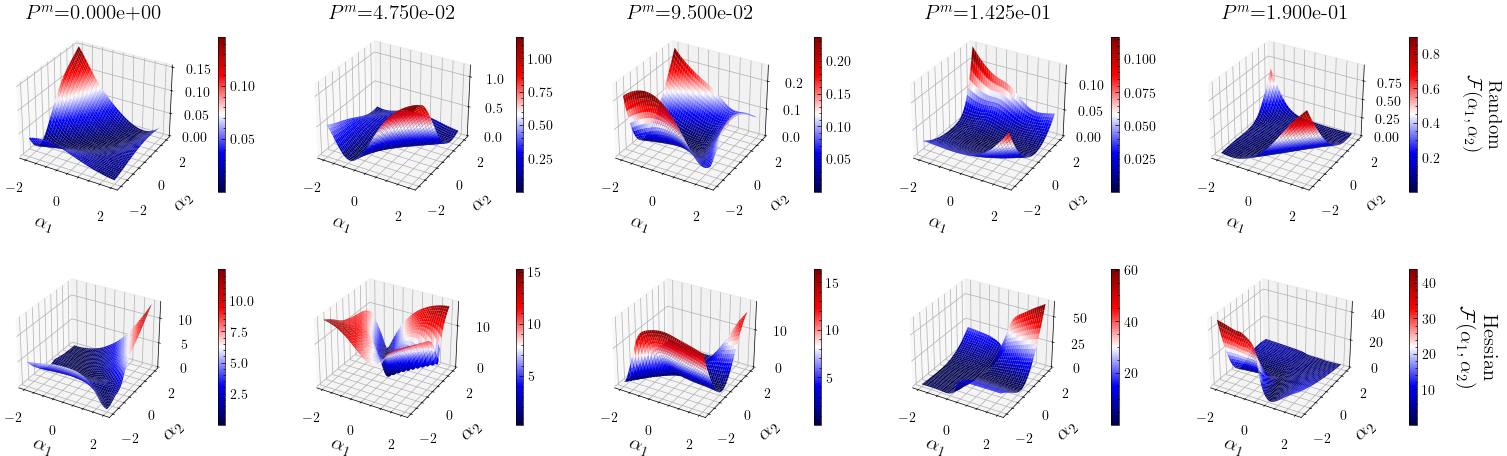

In [ ]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(18, 15), subplot_kw={'projection': '3d'})

# Loop over each of the parameter values
for idx, param in enumerate(PARAM_LIST):

    # Plot the random direction vector subspace projection of the loss landscape
    surf_random = ax[0, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_random[idx]),
        cmap=CMAP,
        linewidth=0,
        antialiased=True
    )
    
    clr_bar1 = fig.colorbar(surf_random, ax=ax[0, idx], shrink=0.10, orientation='vertical', pad=0.15)

    if idx == len(PARAM_LIST) - 1:
        clr_bar1.set_label(
            "Random\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=14,
            rotation=-90,
            labelpad=45
        )

    ax[0, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

    if TOP_PLOT:
        ax[0, idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=15)

    # Plot the Hessian eigenvectors subspace projection of the loss landscape
    surf_hessian = ax[1, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_hessian[idx]),
        cmap=CMAP,
        linewidth=0,
        antialiased=True
    )

    clr_bar2 = fig.colorbar(surf_hessian, ax=ax[1, idx], shrink=0.10, orientation='vertical', pad=0.2)

    if idx == len(PARAM_LIST) - 1:
        clr_bar2.set_label(
            "Hessian\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=15,
            rotation=-90,
            labelpad=45
        )
    
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=15, labelpad=1.1)
    ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=15)

fig.subplots_adjust(left=0.1, right=0.9, hspace=-0.85, top=1.3)

# Output the plots as PDF to the desired directory
loss_landscape_image_name = f"vanilla_nn/loss_landscape_random_seed_{SEED}.pdf"

if SAVE is True and SEMI_SUPERVISED is False:
    print("Saving...")
    
    plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

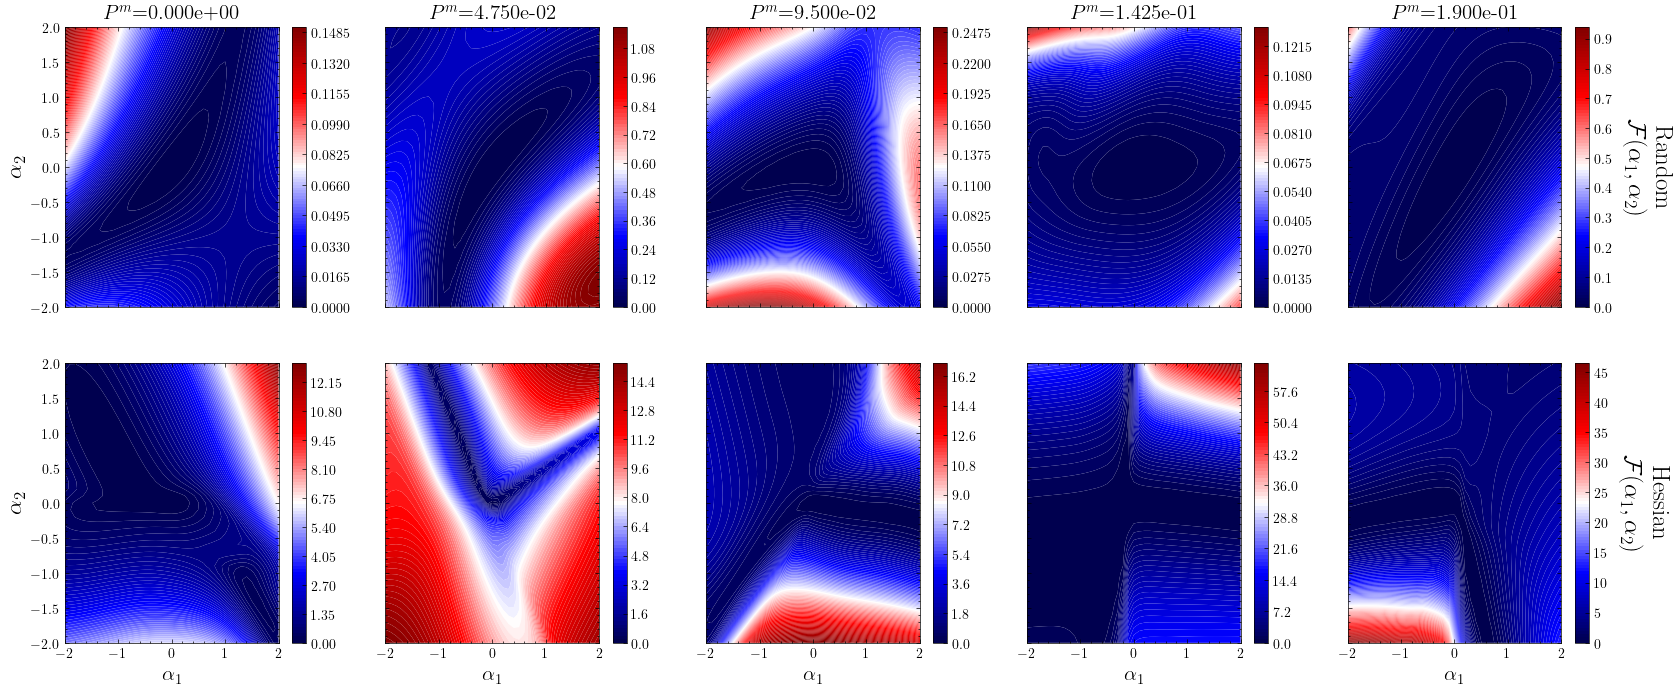

In [ ]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 8), sharex=True, sharey=True)

num_levels: int = 100

# Loop over each of the parameter values
for idx, (param) in enumerate(PARAM_LIST):

    # Plot the random direction vector subspace projection of the loss landscape
    contour_random = ax[0, idx].contourf(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_random[idx]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )

    clr_bar1 = fig.colorbar(contour_random, ax=ax[0, idx], shrink=1, orientation='vertical', pad=0.05)

    if idx == len(PARAM_LIST) - 1:
        clr_bar1.set_label(
            "Random\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=18,
            rotation=-90,
            labelpad=45
        )
    
    if idx == 0:
        ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=17)
        ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=17)

    if TOP_PLOT:
        ax[0, idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=15)

    # Plot the Hessian eigenvectors subspace projection of the loss landscape
    contour_hessian = ax[1, idx].contourf(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_hessian[idx]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )

    clr_bar2 = fig.colorbar(contour_hessian, ax=ax[1, idx], shrink=1, orientation='vertical', pad=0.05)

    if idx == len(PARAM_LIST) - 1:
        clr_bar2.set_label(
            "Hessian\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=18,
            rotation=-90,
            labelpad=45
        )
    
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=15)

contour_image_name = f"vanilla_nn/contour_random_seed_{SEED}.pdf"

if SAVE is True and SEMI_SUPERVISED is False:
    print("Saving...")
    
    plt.savefig(fname=PATH_TO_IM_DIR+contour_image_name, format="pdf", bbox_inches="tight")

plt.show()

## 4.0) Plot network approximation vs. the true (numerical) dynamics 

<>:67: SyntaxWarning: invalid escape sequence '\d'
<>:68: SyntaxWarning: invalid escape sequence '\d'
<>:67: SyntaxWarning: invalid escape sequence '\d'
<>:68: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_2628/3349127369.py:67: SyntaxWarning: invalid escape sequence '\d'
  ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_2628/3349127369.py:68: SyntaxWarning: invalid escape sequence '\d'
  ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


L2 absolute error: 2.21e-02
L2 relative error: 5.35e-02
L2 absolute error: 2.59e-02
L2 relative error: 4.12e-02
L2 absolute error: 4.75e-02
L2 relative error: 3.22e-02
L2 absolute error: 1.59e-01
L2 relative error: 7.21e-02
L2 absolute error: 8.97e-02
L2 relative error: 2.83e-02


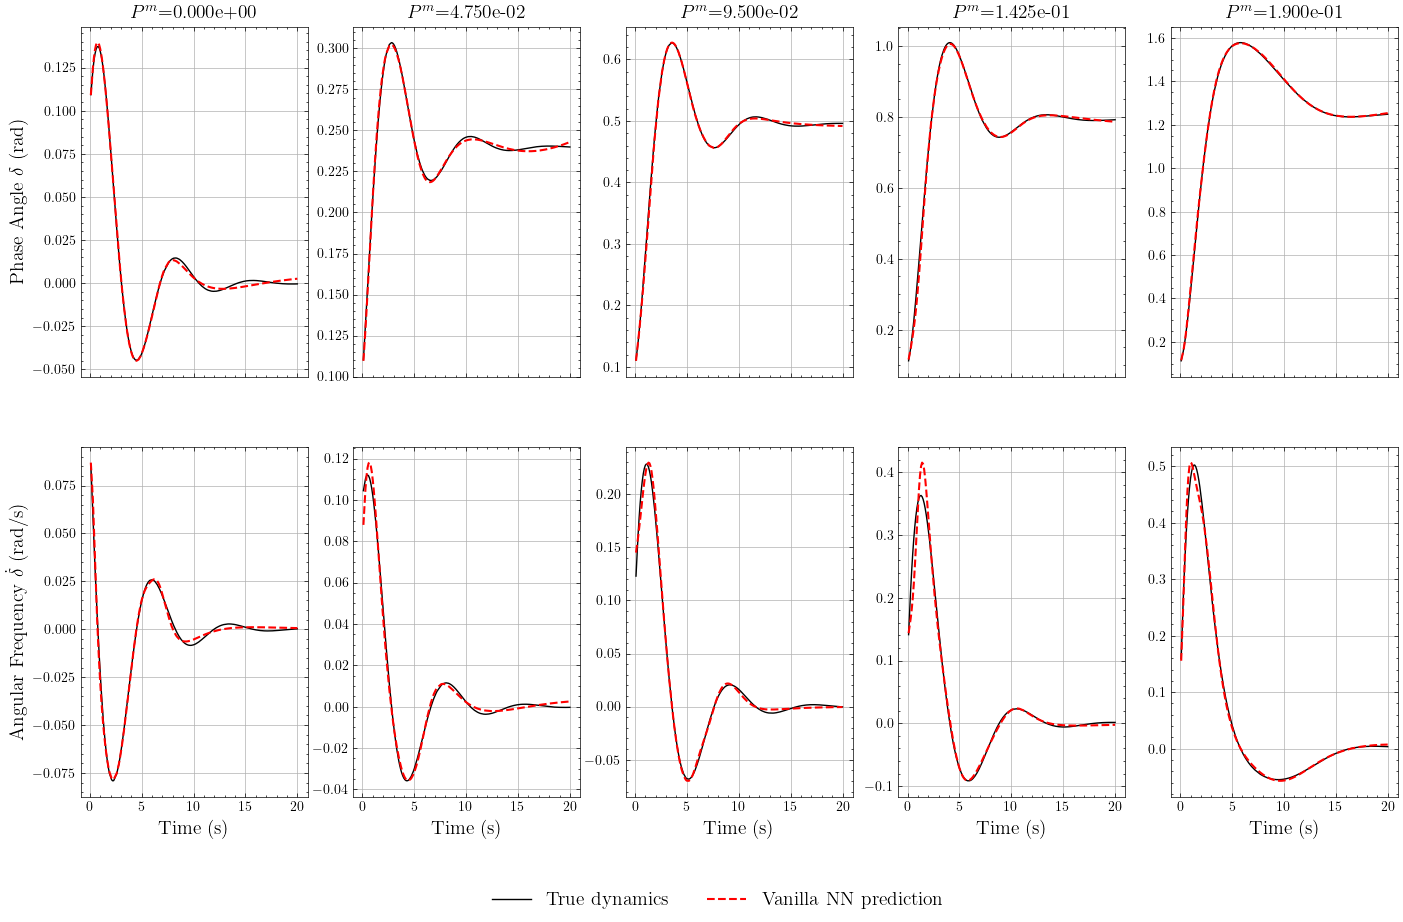

In [ ]:
abs_errors_pinns: list[float] = []
rel_errors_pinns: list[float] = []
pinn_predictions_per_param: list[float] = []

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(17, 10), sharex=True)

for index, (model, param) in enumerate(zip(nn_models, PARAM_LIST)):

    test_times = torch.tensor(
        data=np.array([numerical_domain[id] for id in test_indices])[:, None],
        requires_grad=True,
        dtype=torch.float32
    ).to(device=DEVICE)

    ground_truth_phase_angle = torch.tensor(
        data=np.array([numerical_solutions_exact[index, 0, id] for id in test_indices])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)

    ground_truth_angular_frequency = torch.tensor(
        data=np.array([numerical_solutions_exact[index, 1, id] for id in test_indices])[:, None],
        requires_grad=False,
        dtype=torch.float32
    ).to(device=DEVICE)

    assert ground_truth_angular_frequency.shape[0] == int(N - TRAIN_TEST_SPLIT*N)
    assert ground_truth_phase_angle.shape[0] == int(N - TRAIN_TEST_SPLIT*N)
    assert test_times.shape[0] == int(N - TRAIN_TEST_SPLIT*N)

    nn = model
    nn.eval()
    pred = nn.forward(data=test_times)
    pred_dot = torch.autograd.grad(
        outputs=pred,
        inputs=test_times,
        grad_outputs=torch.ones_like(pred),
        create_graph=False,
        retain_graph=False
    )[0]

    pred_vector = torch.stack(tensors=(pred, pred_dot), dim=0).squeeze()
    label_vector = torch.stack(tensors=(ground_truth_phase_angle, ground_truth_angular_frequency), dim=0).squeeze()

    l2_abs, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)

    print(f"L2 absolute error: {l2_abs:.2e}")
    print(f"L2 relative error: {l2_rel:.2e}")

    abs_errors_pinns.append(l2_abs)
    rel_errors_pinns.append(l2_rel)
    pinn_predictions_per_param.append(pred_vector.detach().numpy())

    ax[0, index].plot(test_times.detach().numpy(), ground_truth_phase_angle.detach().numpy(), color="black", linestyle="-", label="True dynamics")
    ax[0, index].plot(test_times.detach().numpy(), pred.detach().numpy(), color='red', linestyle='--', label='Vanilla NN prediction', linewidth=1.5)
    ax[0, index].grid()
    # ax[0, index].legend(fontsize=12, loc="best")
    ax[0, index].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=14)

    ax[1, index].plot(test_times.detach().numpy(), ground_truth_angular_frequency.detach().numpy(), color="black", linestyle="-", label="True dynamics")
    ax[1, index].plot(test_times.detach().numpy(), pred_dot.detach().numpy(), color='red', linestyle='--', label='Vanilla NN prediction', linewidth=1.5)
    ax[1, index].grid()
    # ax[1, index].legend(fontsize=12, loc="best")
    ax[1, index].set_xlabel("Time (s)", fontsize=14)

    if index == 0:
        ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
        ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)

exact_vs_pred_image: str = f"vanilla_nn/vanilla_nn_vs_ground_truth_seed_{SEED}.pdf"

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize=14)

if SAVE is True and SEMI_SUPERVISED is False:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

plt.show()

### 4.1) Plot the L2 absolute and relative mean per-sample errors of the vanilla NNs against the numerical solutions per parameter value

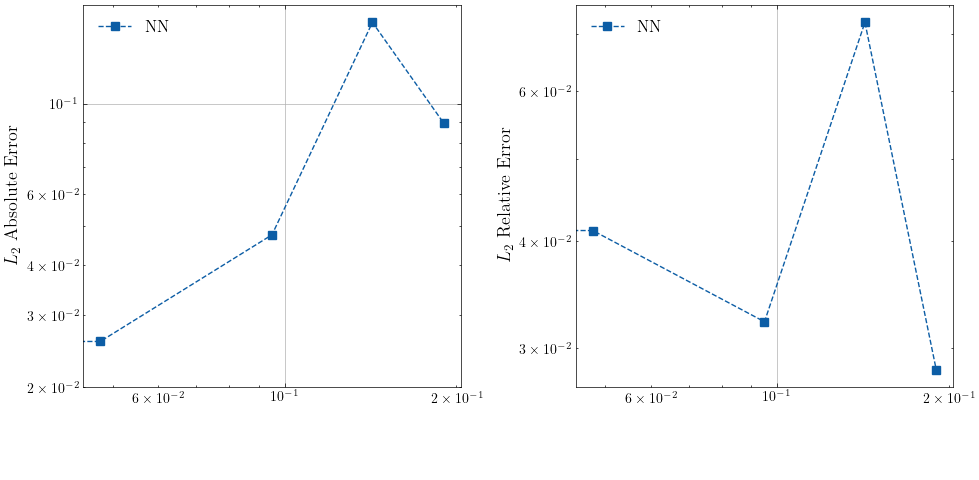

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].loglog(PARAM_LIST, [ls.detach().numpy() for ls in abs_errors_pinns], marker='s', linestyle='--', label="NN")    
ax[0].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[0].set_ylabel("$L_{2}$ Absolute Error", fontsize=13)
ax[0].legend(fontsize=12)
ax[0].grid()

ax[1].loglog(PARAM_LIST, [ls.detach().numpy() for ls in rel_errors_pinns], marker='s', linestyle='--', label="NN")    
ax[1].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[1].set_ylabel("$L_{2}$ Relative Error", fontsize=13)
# ax[1].set_xticklabels()
ax[1].legend(fontsize=12)
ax[1].grid()

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

### 4.2) Plot the training loss $\mathcal{L}_{\mathrm{NN}}$ per epoch for each parameter value

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_2628/703868973.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("Training loss $\mathcal{L}_{\mathrm{NN}}$", fontsize=16)


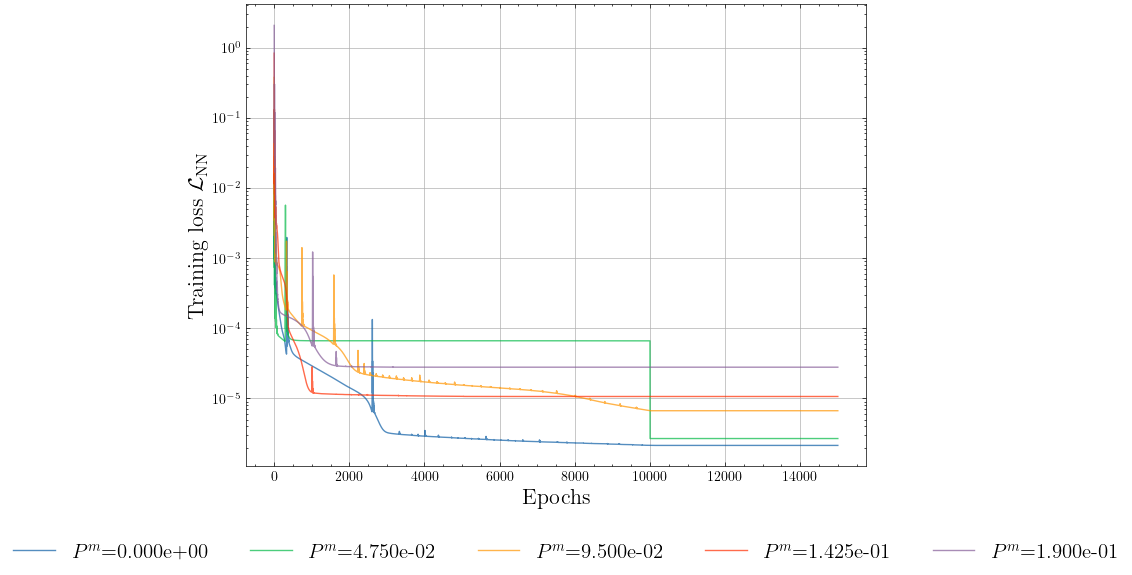

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for (param, training_loss) in zip(PARAM_LIST, training_losses_per_param):
    ax.semilogy(
        range(1, EPOCHS+1),
        training_loss,
        alpha=0.7,
        label=f"{VARYING_PARAM_NOTATION}={param:.3e}"
    )

ax.set_ylabel("Training loss $\mathcal{L}_{\mathrm{NN}}$", fontsize=16)
ax.set_xlabel("Epochs", fontsize=16)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(PARAM_LIST), bbox_to_anchor=(0.525, -0.08), fontsize=15)

training_losses_plot = f"{VARYING_PARAM}_training_losses_seed_{SEED}.pdf"

plt.show()

### 4.3) Plot the $L_2$/Euclidean norm of the training loss gradient $\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{NN}} \rVert_2$ per Adam epochs for each parameter value

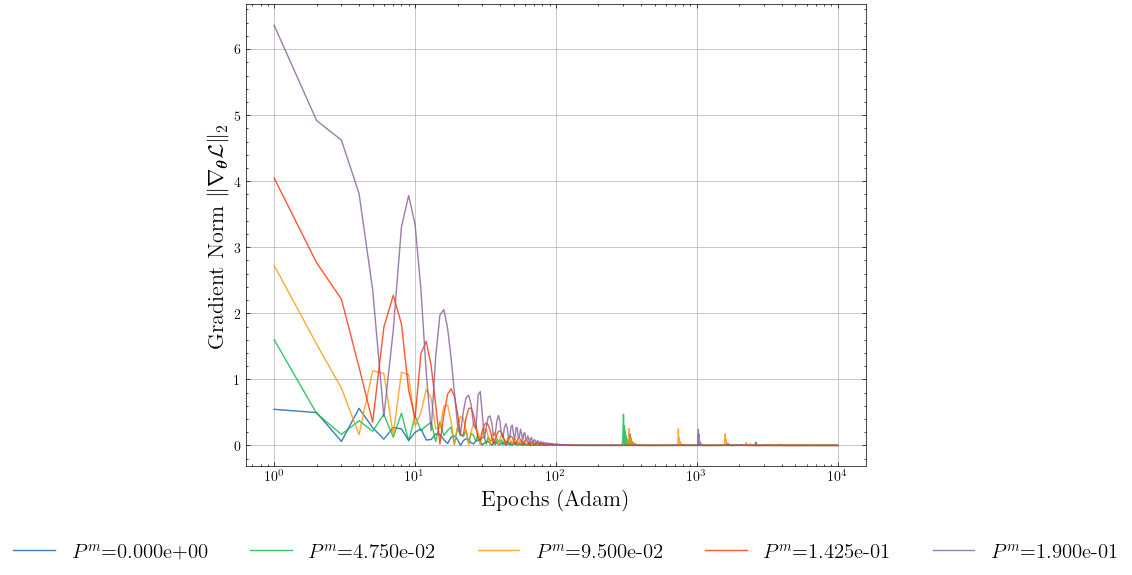

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for param, grad_norm in zip(PARAM_LIST, gradient_norm_per_param):
    ax.semilogx(
        range(1, EPOCHS_ADAM+1),
        grad_norm,
        label=f"{VARYING_PARAM_NOTATION}={param:.3e}",
        alpha=0.8
    )

ax.set_ylabel(r"Gradient Norm $\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}\rVert_{2}$", fontsize=16)
ax.set_xlabel("Epochs (Adam)", fontsize=16)
ax.grid()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(PARAM_LIST), bbox_to_anchor=(0.525, -0.08), fontsize=15)

plt.show()

## 5.0) Export the data for uncertainty quantification

In [45]:
if SAVE is True and SEMI_SUPERVISED is True:

    print("Saving...")

    abs_errors_pinns_export = [err.item() for err in abs_errors_pinns]
    rel_errors_pinns_export = [err.item() for err in rel_errors_pinns]

    errors_output = f"vanilla_nn/l2_errors/semi_supervised/semi_supervised_abs_rel_errors_seed_{SEED}_Nd_{rand_index.shape[0]}.npz"
    
    np.savez(PATH_TO_IM_DIR+errors_output, absolute_errors=abs_errors_pinns_export, relative_errors=rel_errors_pinns_export)

elif SAVE is True and SEMI_SUPERVISED is False:

    print("Saving...")

    abs_errors_pinns_export = [err.item() for err in abs_errors_pinns]
    rel_errors_pinns_export = [err.item() for err in rel_errors_pinns]

    errors_output = f"vanilla_nn/l2_errors/abs_rel_errors_seed_{SEED}.npz"
    
    np.savez(PATH_TO_IM_DIR+errors_output, absolute_errors=abs_errors_pinns_export, relative_errors=rel_errors_pinns_export)

In [ ]:
training_loss_output = f"vanilla_nn/training_loss/training_loss_per_epoch_seed_{SEED}.npz"

if SAVE is True and SEMI_SUPERVISED is False:
    print("Saving...")

    np.savez(
        PATH_TO_IM_DIR+training_loss_output,
        total_loss=np.array(training_losses_per_param)
    )

In [ ]:
test_loss_output = f"vanilla_nn/rel_error_per_epoch/rel_errors_per_epoch_seed_{SEED}.npz"

if SAVE is True and SEMI_SUPERVISED is False:
    print("Saving...")

    np.savez(
        PATH_TO_IM_DIR+test_loss_output,
        test_loss=np.array(test_losses_per_param_per_epoch)
    )

In [ ]:
test_times = torch.tensor(
    data=np.array([numerical_domain[id] for id in test_indices])[:, None],
    requires_grad=True,
    dtype=torch.float32
).to(device=DEVICE)

all_pa = torch.tensor(
    data=np.array([numerical_solutions_exact[:, 0, id] for id in test_indices])[:, None],
    requires_grad=False,
    dtype=torch.float32
).to(device=DEVICE)

all_af = torch.tensor(
    data=np.array([numerical_solutions_exact[:, 1, id] for id in test_indices])[:, None],
    requires_grad=False,
    dtype=torch.float32
).to(device=DEVICE)

print(np.array(pinn_predictions_per_param)[:, 0, :].shape)
print(np.array(all_pa).squeeze().T.shape)
print(test_times.detach().numpy().shape)

In [ ]:
pinn_predictions_vs_rk45 = f"vanilla_nn/nn_pred_vs_rk45/vanilla_nn_pred_vs_rk45_seed_{SEED}.npz"

if SAVE is True and SEMI_SUPERVISED is False:
    print("Saving...")

    np.savez(
        PATH_TO_IM_DIR+pinn_predictions_vs_rk45,
        pred=np.array(pinn_predictions_per_param)[:, 0, :],
        pred_dot=np.array(pinn_predictions_per_param)[:, 1, :],
        phase_angle_label = np.array(all_pa).squeeze().T,
        angular_frequency_label = np.array(all_af).squeeze().T,
        test_times = test_times.detach().numpy()
    )

In [ ]:
loss_grad_norms = f"vanilla_nn/gradient_norms/loss_grad_norm_per_epoch_seed_{SEED}.npz"

if SAVE is True and SEMI_SUPERVISED is False:
    print("Saving...")

    np.savez(
        PATH_TO_IM_DIR+loss_grad_norms,
        grad_norms=np.array(gradient_norm_per_param)
    )